# COURSE: A deep understanding of deep learning
## SECTION: Understand and design CNNs
### LECTURE: The EMNIST dataset (letter recognition)
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import torchvision

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Temp\ipykernel_20716\2439941862.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Import and inspect the data

In [3]:
# download the dataset
cdata = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)

# more info: https://www.nist.gov/itl/products-and-services/emnist-dataset

In [4]:
# inspect the data

# the categories (but how many letters??)
print(cdata.classes)
print(str(len(cdata.classes)) + ' classes')

print('\nData size:')
print(cdata.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
images = cdata.data.view([124800,1,28,28]).float()
print('\nTensor data:')
print(images.shape)


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])

Tensor data:
torch.Size([124800, 1, 28, 28])


In [5]:
# brief aside: class 'N/A' doesn't exist in the data.
print( torch.sum(cdata.targets==0) )

# However, it causes problems in one-hot encoding...
torch.unique(cdata.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [6]:
cdata.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [7]:
# so therefore we'll eliminate it and subtract 1 from the original

# remove the first class category
letterCategories = cdata.classes[1:]

# relabel labels to start at 0
labels = copy.deepcopy(cdata.targets)-1
print(labels.shape)

### 
print( torch.sum(labels==0) )
torch.unique(labels)

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

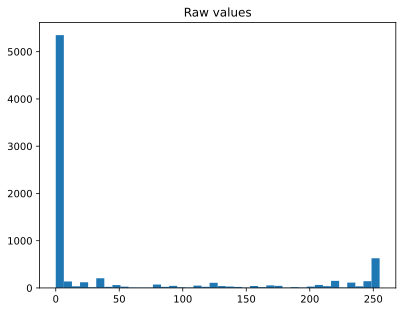

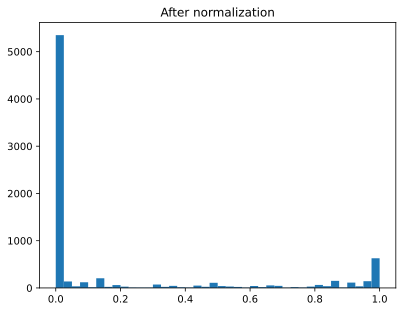

In [8]:
# next issue: do we need to normalize the images?
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title('Raw values')
plt.show()

# yarp.
images /= torch.max(images)

plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title('After normalization')
plt.show()

# Create train/test groups using DataLoader

In [9]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 64
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [10]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


# Create the DL model

In [11]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class emnistnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()
      
      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1,6,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(6,6,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)

      
      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(7*7*6,50)
      self.fc2 = nn.Linear(50,26)

    def forward(self,x):
      
      if self.print: print(f'Input: {list(x.shape)}')
      
      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')
      
      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = self.fc2(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = emnistnet(printtoggle).to(device)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [12]:
# test the model with one batch
net,lossfun,_ = makeTheNet(True)
net.cpu()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: [64, 1, 28, 28]
First CPR block: [64, 6, 14, 14]
Second CPR block: [64, 6, 7, 7]
Vectorized: [64, 294]
Final output: [64, 26]

Output size:
torch.Size([64, 26])
 
Loss:
tensor(3.2723, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [15]:
# a function that trains the model

def function2trainTheModel(net, lossfun, optimizer, train_loader, test_loader, numepochs=5):

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

# Run the model and show the results!

In [16]:
# ~2 minutes with 10 epochs on GPU (8 mins on the CPU!)
net, lossfun, optimizer = makeTheNet()
trainLoss,testLoss,trainErr,testErr,net = function2trainTheModel(net, lossfun, optimizer, train_loader, test_loader, 5)

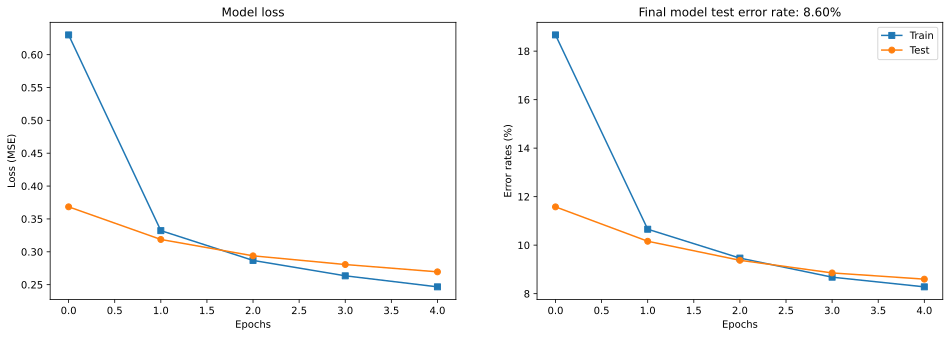

In [17]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

 ------
# Start transfer learning
 ------

# Load data

In [25]:
import torchvision.transforms as T
custom_transform = T.Compose([
  T.ToTensor(),
])

digit_cdata_train = torchvision.datasets.EMNIST(root='emnist',split='digits',download=True, train=True, transform=custom_transform)
digit_cdata_test = torchvision.datasets.EMNIST(root='emnist',split='digits',download=True, train=False, transform=custom_transform)

In [26]:
digit_train_loader = DataLoader(digit_cdata_train,batch_size=batchsize,shuffle=True,drop_last=True)
digits_test_loader = DataLoader(digit_cdata_test,batch_size=len(digit_cdata_test))

# Fine-tuned net

In [27]:
digit_fine_tuned_net, lossfun, optimizer = makeTheNet()

# Copy weights
for target,source in zip(digit_fine_tuned_net.named_parameters(), net.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

# Correct output layer
digit_fine_tuned_net.fc2 = nn.Linear(50, 10)

print(digit_fine_tuned_net)

emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [28]:
trainLoss,testLoss,trainErr,testErr,digit_fine_tuned_net = function2trainTheModel(digit_fine_tuned_net, lossfun, optimizer, digit_train_loader, digits_test_loader, 1)

In [30]:
print(f"Final error train: {trainErr[-1]:.2f}")
print(f"Final error test: {testErr[-1]:.2f}")

Final error train: 2.31
Final error test: 1.16


# Only fine-tine the final layer (freeze the rest)

In [32]:
digit_fine_tuned_freeze_net, lossfun, optimizer = makeTheNet()

# Copy weights
for target,source in zip(digit_fine_tuned_freeze_net.named_parameters(), net.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )
  target[1].requires_grad = False

# Correct output layer (automatically has requires_grad = True
digit_fine_tuned_freeze_net.fc2 = nn.Linear(50, 10)

print(digit_fine_tuned_freeze_net)

emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [33]:
trainLoss,testLoss,trainErr,testErr,digit_fine_tuned_net = function2trainTheModel(digit_fine_tuned_freeze_net, lossfun, optimizer, digit_train_loader, digits_test_loader, 1)

In [34]:
print(f"Final error train: {trainErr[-1]:.2f}")
print(f"Final error test: {testErr[-1]:.2f}")

Final error train: 90.38
Final error test: 90.23
